In [ ]:
# # Switch to tensorflow 1.x
# %tensorflow_version 1.x

TensorFlow 1.x selected.


In [1]:
import tensorflow as tf
from Compute_Jacobian import jacobian # Please download 'Compute_Jacobian.py' in the repository 
import numpy as np
import timeit
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

os.environ["KMP_WARNINGS"] = "FALSE" 
import timeit

import sys

import scipy
import scipy.io
import time
import logging

import os.path
import shutil
from datetime import datetime
import pickle


In [2]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [3]:
class PINN:
    def __init__(self, layers, X_u, Y_u, X_r, Y_r ,mode ,  sess):


        self.mode = mode

        self.dirname, logpath = self.make_output_dir()
        self.logger = self.get_logger(logpath)     

        self.mu_X, self.sigma_X = X_r.mean(0), X_r.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]

        # Normalize
        self.X_u = (X_u - self.mu_X) / self.sigma_X
        self.Y_u = Y_u
        self.X_r = (X_r - self.mu_X) / self.sigma_X
        self.Y_r = Y_r

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
            
        # Define the size of the Kernel
        self.kernel_size = X_u.shape[0]
        # Define Tensorflow session
        self.sess = sess# tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        self.x_u_ntk_tf = tf.placeholder(tf.float32, shape=(self.kernel_size, 1))
        self.x_r_ntk_tf = tf.placeholder(tf.float32, shape=(self.kernel_size, 1))


        # Evaluate predictions
        self.u_bc_pred = self.net_u(self.x_bc_tf)

        self.u_pred = self.net_u(self.x_u_tf)
        self.r_pred = self.net_r(self.x_r_tf)
        
        self.u_ntk_pred = self.net_u(self.x_u_ntk_tf)
        self.r_ntk_pred = self.net_r(self.x_r_ntk_tf)
     
        # Boundary loss
        self.loss_bcs = tf.reduce_mean(tf.square(self.u_bc_pred - self.u_bc_tf))

        # Residual loss        
        self.loss_res =  tf.reduce_mean(tf.square(self.r_tf - self.r_pred))
        
        # Total loss
        self.loss = self.loss_res + self.loss_bcs

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-5
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        # To compute NTK, it is better to use SGD optimizer
        # since the corresponding gradient flow is not exactly same.
        self.train_op = tf.train.GradientDescentOptimizer(starter_learning_rate).minimize(self.loss)
        # self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)


        
        # Compute the Jacobian for weights and biases in each hidden layer  
        self.J_u = self.compute_jacobian(self.u_ntk_pred) 
        self.J_r = self.compute_jacobian(self.r_ntk_pred)
        
        # The empirical NTK = J J^T, compute NTK of PINNs 
        self.K_uu = self.compute_ntk(self.J_u, self.x_u_ntk_tf, self.J_u, self.x_u_ntk_tf)
        self.K_ur = self.compute_ntk(self.J_u, self.x_u_ntk_tf, self.J_r, self.x_r_ntk_tf)
        self.K_rr = self.compute_ntk(self.J_r, self.x_r_ntk_tf, self.J_r, self.x_r_ntk_tf)
        
        # Logger
        # Loss logger
        self.loss_bcs_log = []
        self.loss_res_log = []

        # NTK logger 
        self.K_uu_log = []
        self.K_rr_log = []
        self.K_ur_log = []
        
        # Weights logger 
        self.weights_log = []
        self.biases_log = []
       # Gradients Storage



        # Generate dicts for gradients storage
        self.dict_gradients_res_layers = self.generate_grad_dict()
        self.dict_gradients_bc_layers = self.generate_grad_dict()

        self.grad_res = []
        self.grad_bc = []
        self.grad_bc_list = []

        for i in range(len(self.layers) - 1):
            self.grad_res.append(tf.gradients(self.loss_res, self.weights[i])[0])
            self.grad_bc.append(tf.gradients(self.loss_bcs, self.weights[i])[0])

        for i in range(len(self.layers) - 1):
            self.grad_bc_list.append(tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_bc[i])))

        self.adaptive_constant_bc = tf.reduce_max(tf.stack(self.grad_bc_list))

        self.loss_tensor_list = [self.loss ,  self.loss_res,  self.loss_bcs] 
        self.loss_list = ["total loss" , "loss_res" , "loss_bcs"] 

        self.epoch_loss = dict.fromkeys(self.loss_list, 0)
        self.loss_history = dict((loss, []) for loss in self.loss_list)
        

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()

        self.sess.run(init)
        

###############################################################################################################

    def generate_grad_dict(self):
        num = len(self.layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)
    
    # NTK initialization
    def NTK_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        std = 1. / np.sqrt(in_dim)
        return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * std,
                           dtype=tf.float32)

     # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.NTK_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.random.normal([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # Evaluates the PDE solution
    def net_u(self, x):
        u = self.forward_pass(x)
        return u

    # Forward pass for the residual
    def net_r(self, x):
        u = self.net_u(x)

        u_x = tf.gradients(u, x)[0] / self.sigma_x
        u_xx = tf.gradients(u_x, x)[0] / self.sigma_x

        res_u = u_xx
        return res_u
    
    # Compute Jacobian for each weights and biases in each layer and retrun a list 
    def compute_jacobian(self, f):
        J_list =[]
        L = len(self.weights)    
        for i in range(L):
            J_w = jacobian(f, self.weights[i])
            J_list.append(J_w)
     
        for i in range(L):
            J_b = jacobian(f, self.biases[i])
            J_list.append(J_b)
        return J_list
    
    # Compute the empirical NTK = J J^T
    def compute_ntk(self, J1_list, x1, J2_list, x2):
        D = x1.shape[0]
        N = len(J1_list)
        
        Ker = tf.zeros((D,D))
        for k in range(N):
            J1 = tf.reshape(J1_list[k], shape=(D,-1))
            J2 = tf.reshape(J2_list[k], shape=(D,-1))
            
            K = tf.matmul(J1, tf.transpose(J2))
            Ker = Ker + K
        return Ker
            
    # Trains the model by minimizing the MSE loss
    def trainmb(self, nIter=10000, batch_size=128, log_NTK=True, log_weights=True):


        itValues = [1,100,1000,39999]
        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_bc_tf: self.X_u, self.u_bc_tf: self.Y_u,
                       self.x_u_tf: self.X_u, self.x_r_tf: self.X_r,
                       self.r_tf: self.Y_r
                       }
        
            # Run the Tensorflow session to minimize the loss
            _, batch_losses = self.sess.run([self.train_op, self.loss_tensor_list] ,tf_dict)

            # self.print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_res_value = self.sess.run([self.loss_bcs, self.loss_res], tf_dict)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                self.print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e ,Time: %.2f' %  (it, loss_value, loss_bcs_value, loss_res_value, elapsed))
                
            if log_NTK:
                # provide x, x' for NTK
                if it % 100 == 0:

                    adaptive_constant_bc = self.sess.run([self.adaptive_constant_bc],  tf_dict)
                    print(adaptive_constant_bc[0])
                   
                    self.print("Compute NTK...")
                    tf_dict2 = {self.x_u_ntk_tf: self.X_u, 
                               self.x_r_ntk_tf: self.X_r
                               }
                    K_uu_value, K_ur_value, K_rr_value = self.sess.run([self.K_uu,  self.K_ur,  self.K_rr], tf_dict2)
                    self.K_uu_log.append(K_uu_value)
                    self.K_ur_log.append(K_ur_value)
                    self.K_rr_log.append(K_rr_value)
            start_time = timeit.default_timer()

            if it in itValues:
                    self.plot_layerLoss(tf_dict , it)
                    self.print("Gradients information stored ...")

            sys.stdout.flush()
            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])
            
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    # Evaluates predictions at test points
    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_r_tf: X_star}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star
 ############################################################

    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values

  ############################################################
###################################################################################################################


    def plot_layerLoss(self , tf_dict , epoch):
        ## Gradients #
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res, grad_bc  = self.sess.run([ self.grad_res[i],self.grad_bc[i]], feed_dict=tf_dict)

            # save gradients of loss_r and loss_u
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res.flatten())
            self.dict_gradients_bc_layers['layer_' + str(i + 1)].append(grad_bc.flatten())

        num_hidden_layers = num_layers -1
        cnt = 1
        fig = plt.figure(4, figsize=(13, 4))
        for j in range(num_hidden_layers):
            ax = plt.subplot(1, num_hidden_layers, cnt)
            ax.set_title('Layer {}'.format(j + 1))
            ax.set_yscale('symlog')
            gradients_res = self.dict_gradients_res_layers['layer_' + str(j + 1)][-1]
            gradients_bc = self.dict_gradients_bc_layers['layer_' + str(j + 1)][-1]

            sns.distplot(gradients_res, hist=False,kde_kws={"shade": False},norm_hist=True,  label=r'$\nabla_\theta \mathcal{L}_r$')

            sns.distplot(gradients_bc, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{bc}}$')

            #ax.get_legend().remove()
            ax.set_xlim([-1.0, 1.0])
            #ax.set_ylim([0, 150])
            cnt += 1
        handles, labels = ax.get_legend_handles_labels()

        fig.legend(handles, labels, loc="center",  bbox_to_anchor=(0.5, -0.03),borderaxespad=0,bbox_transform=fig.transFigure, ncol=2)
        text = 'layerLoss_epoch' + str(epoch) +'.png'
        plt.savefig(os.path.join(self.dirname,text) , bbox_inches='tight')
        plt.close("all")

    # #########################
    # def make_output_dir(self):
        
    #     if not os.path.exists("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints"):
    #         os.mkdir("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints")
    #     dirname = os.path.join("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
    #     os.mkdir(dirname)
    #     text = 'output.log'
    #     logpath = os.path.join(dirname, text)
    #     shutil.copyfile('/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/M2.py', os.path.join(dirname, 'M2.py'))

    #     return dirname, logpath
    
    # # ###########################################################
    def make_output_dir(self):
        
        if not os.path.exists("checkpoints"):
            os.mkdir("checkpoints")
        dirname = os.path.join("checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
        os.mkdir(dirname)
        text = 'output.log'
        logpath = os.path.join(dirname, text)
        shutil.copyfile('M1.ipynb', os.path.join(dirname, 'M1.ipynb'))
        return dirname, logpath
    

    def get_logger(self, logpath):
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.DEBUG)
        sh = logging.StreamHandler()
        sh.setLevel(logging.DEBUG)        
        sh.setFormatter(logging.Formatter('%(message)s'))
        fh = logging.FileHandler(logpath)
        logger.addHandler(sh)
        logger.addHandler(fh)
        return logger
    
    def print(self, *args):
        for word in args:
            if len(args) == 1:
                self.logger.info(word)
            elif word != args[-1]:
                for handler in self.logger.handlers:
                    handler.terminator = ""
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32: 
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)
            else:
                for handler in self.logger.handlers:
                    handler.terminator = "\n"
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32:
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)


    def plot_loss_history(self , path):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        for key in self.loss_history:
            self.print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
            ax.semilogy(self.loss_history[key], label=key)
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        plt.savefig(path)
        #plt.show()
       #######################
    def save_NN(self):

        uv_weights = self.sess.run(self.weights)
        uv_biases = self.sess.run(self.biases)

        with open(os.path.join(self.dirname,'model.pickle'), 'wb') as f:
            pickle.dump([uv_weights, uv_biases], f)
            self.print("Save uv NN parameters successfully in %s ..." , self.dirname)

        # with open(os.path.join(self.dirname,'loss_history_BFS.pickle'), 'wb') as f:
        #     pickle.dump(self.loss_rec, f)
        with open(os.path.join(self.dirname,'loss_history_BFS.png'), 'wb') as f:
            self.plot_loss_history(f)

        return self.dirname
    
    def plot_ntk(self):
        # Create empty lists for storing the eigenvalues of NTK
        lambda_K_log = []
        lambda_K_uu_log = []
        lambda_K_ur_log = []
        lambda_K_rr_log = []

        # Restore the NTK
        K_uu_list = self.K_uu_log
        K_ur_list = self.K_ur_log
        K_rr_list = self.K_rr_log
        K_list = []
            
        for k in range(len(K_uu_list)):
            K_uu = K_uu_list[k]
            K_ur = K_ur_list[k]
            K_rr = K_rr_list[k]
            
            K = np.concatenate([np.concatenate([K_uu, K_ur], axis = 1), np.concatenate([K_ur.T, K_rr], axis = 1)], axis = 0)
            K_list.append(K)

            # Compute eigenvalues
            lambda_K, _ = np.linalg.eig(K)
            lambda_K_uu, _ = np.linalg.eig(K_uu)
            lambda_K_rr, _ = np.linalg.eig(K_rr)
            
            # Sort in descresing order
            lambda_K = np.sort(np.real(lambda_K))[::-1]
            lambda_K_uu = np.sort(np.real(lambda_K_uu))[::-1]
            lambda_K_rr = np.sort(np.real(lambda_K_rr))[::-1]
            
            # Store eigenvalues
            lambda_K_log.append(lambda_K)
            lambda_K_uu_log.append(lambda_K_uu)
            lambda_K_rr_log.append(lambda_K_rr)
        fig = plt.figure(figsize=(18, 5))
        plt.subplot(1,3,1)
        for i in range(1, len(lambda_K_log), 10):
            plt.plot(lambda_K_log[i], '--')
        plt.xscale('log')
        plt.yscale('log')
        plt.title(r'Eigenvalues of ${K}$')
        plt.tight_layout()

        plt.subplot(1,3,2)
        for i in range(1, len(lambda_K_uu_log), 10):
            plt.plot(lambda_K_uu_log[i], '--')
        plt.xscale('log')
        plt.yscale('log')
        plt.title(r'Eigenvalues of ${K}_{uu}$')
        plt.tight_layout()

        plt.subplot(1,3,3)
        for i in range(1, len(lambda_K_log), 10):
            plt.plot(lambda_K_rr_log[i], '--')
        plt.xscale('log')
        plt.yscale('log')
        plt.title(r'Eigenvalues of ${K}_{rr}$')
        plt.tight_layout()
        plt.savefig(os.path.join(self.dirname,"ntk.png"))
        plt.close("all")

    def plt_prediction(self , X_star , u_star , u_pred):
        fig = plt.figure(figsize=(12, 5))
        plt.subplot(1,2,1)
        plt.plot(X_star, u_star, label='Exact')
        plt.plot(X_star, u_pred, '--', label='Predicted')
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.legend(loc='upper right')

        plt.subplot(1,2,2)
        plt.plot(X_star, np.abs(u_star - u_pred), label='Error')
        plt.yscale('log')
        plt.xlabel('$x$')
        plt.ylabel('Point-wise error')
        plt.tight_layout()
        plt.savefig(os.path.join(self.dirname,"prediction.png"))
        plt.close("all")


In [4]:
# Define solution and its Laplace
a = 4

def u(x, a):
  return np.sin(np.pi * a * x)

def u_xx(x, a):
  return -(np.pi * a)**2 * np.sin(np.pi * a * x)

In [5]:
#test_method(mtd , layers,  X_u, Y_u, X_r, Y_r ,  X_star , u_star , r_star  , nIter ,batch_size , bcbatch_size , ubatch_size)
def test_method(method , layers,  X_u, Y_u, X_r, Y_r , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size , mode):


    gpu_options = tf.GPUOptions(visible_device_list="0")
    tf.reset_default_graph()
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
        # sess.run(init)

        model = PINN(layers, X_u, Y_u, X_r, Y_r , mode , sess)    

        # Train model
        start_time = time.time()

        if method =="full_batch":
            print("full_batch method is used")
            model.train(nIter  , bcbatch_size , ubatch_size  )
        elif method =="mini_batch":
            print("mini_batch method is used")
            model.trainmb(nIter, mbbatch_size)
        else:
            print("unknown method!")
        elapsed = time.time() - start_time

        # Predictions
        u_pred = model.predict_u(X_star)
        r_pred = model.predict_r(X_star)
        # Predictions

        sess.close()   

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(r_star, 2)

    print('elapsed: {:.2e}'.format(elapsed))

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_r: {:.2e}'.format(error_r))


    return [elapsed, error_u , error_r ]



In [6]:
# Define computional domain
bc1_coords = np.array([[0.0], [0.0]])
bc2_coords = np.array([[1.0], [1.0]])
dom_coords = np.array([[0.0], [1.0]])

# Training data on u(x) -- Dirichlet boundary conditions

nn  = 100

X_bc1 = dom_coords[0, 0] * np.ones((nn // 2, 1))
X_bc2 = dom_coords[1, 0] * np.ones((nn // 2, 1))
X_u = np.vstack([X_bc1, X_bc2])
Y_u = u(X_u, a)

X_r = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
Y_r = u_xx(X_r, a)

nn = 1000
X_star = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
u_star = u(X_star, a)
r_star = u_xx(X_star, a)

nIter =40001
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 128



# Define model
mode = 'M1'
layers = [1, 500, 1]



iterations = 1
methods = [ "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    error_r_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler
        gpu_options = tf.GPUOptions(visible_device_list="0")
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:

            model = PINN(layers, X_u, Y_u, X_r, Y_r , mode , sess)    

            # Train model
            start_time = time.time()

            if mtd =="full_batch":
                print("full_batch method is used")
                model.train(nIter  , bcbatch_size , ubatch_size  )
            elif mtd =="mini_batch":
                print("mini_batch method is used")
                model.trainmb(nIter, mbbatch_size)
            else:
                print("unknown method!")
            elapsed = time.time() - start_time

            # Predictions
            u_pred = model.predict_u(X_star)
            r_pred = model.predict_r(X_star)
            # Predictions
            model.save_NN()
            model.plot_ntk()
 

            error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
            error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(r_star, 2)

            print('elapsed: {:.2e}'.format(elapsed))

            print('Relative L2 error_u: {:.2e}'.format(error_u))
            print('Relative L2 error_r: {:.2e}'.format(error_r))


            print('elapsed: {:.2e}'.format(elapsed))
            print('Relative L2 error_u: {:.2e}'.format(error_u))
            print('Relative L2 error_v: {:.2e}'.format(error_r))

            model.plt_prediction( X_star , u_star , u_pred)
            sess.close()  
            
        time_list.append(elapsed)
        error_u_list.append(error_u)
        error_r_list.append(error_r)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    print("average of error_v_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list ,error_r_list ]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat(os.path.join(model.dirname,""+mtd+"_model"+mode+"_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(bcbatch_size)+"_n"+str(iterations)+"_nIter"+str(nIter)+".mat" , result_dict))




Method:  mini_batch
Epoch:  1










2023-12-08 23:34:41.940912: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 23:34:41.961980: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-12-08 23:34:41.962597: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555e53fd7030 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-08 23:34:41.962609: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-08 23:34:41.963388: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



mini_batch method is used


It: 0, Loss: 9.549e+03, Loss_bcs: 1.280e+00, Loss_res: 9.548e+03 ,Time: 0.33
Compute NTK...
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecate

elapsed: 6.89e+01
Relative L2 error_u: 7.65e-02
Relative L2 error_r: 7.60e-03
elapsed: 6.89e+01
Relative L2 error_u: 7.65e-02
Relative L2 error_v: 7.60e-03


Method:  mini_batch

average of time_list: 68.88730430603027
average of error_u_list: 0.07648353358277864
average of error_v_list: 0.0075999168203618435


TypeError: join() argument must be str or bytes, not 'dict'

In [ ]:
# Define model
layers = [1, 512, 1]  
# layers = [1, 512, 512, 512, 1]  


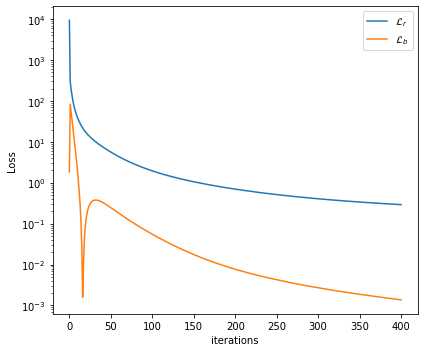

In [10]:
loss_bcs = model.loss_bcs_log
loss_res = model.loss_res_log

fig = plt.figure(figsize=(6,5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{b}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

Relative L2 error_u: 3.05e-02
Relative L2 error_r: 4.16e-03


**NTK Eigenvalues**

**Change of NTK**

In [ ]:
# Change of the NTK
NTK_change_list = []
K0 = K_list[0]
for K in K_list:
    diff = np.linalg.norm(K - K0) / np.linalg.norm(K0) 
    NTK_change_list.append(diff)

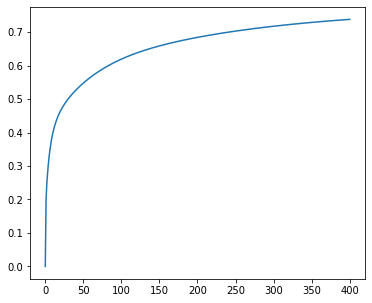

In [ ]:
fig = plt.figure(figsize=(6,5))
plt.plot(NTK_change_list)


**Change of NN Params**

In [ ]:
# Change of the weights and biases
def compute_weights_diff(weights_1, weights_2):
    weights = []
    N = len(weights_1)
    for k in range(N):
        weight = weights_1[k] - weights_2[k]
        weights.append(weight)
    return weights

def compute_weights_norm(weights, biases):
    norm = 0
    for w in weights:
        norm = norm + np.sum(np.square(w))
    for b in biases:
        norm = norm + np.sum(np.square(b))
    norm = np.sqrt(norm)
    return norm

# Restore the list weights and biases
weights_log = model.weights_log
biases_log = model.biases_log

weights_0 = weights_log[0]
biases_0 = biases_log[0]

# Norm of the weights at initialization
weights_init_norm = compute_weights_norm(weights_0, biases_0)

weights_change_list = []

N = len(weights_log)
for k in range(N):
    weights_diff = compute_weights_diff(weights_log[k], weights_log[0])
    biases_diff = compute_weights_diff(biases_log[k], biases_log[0])
    
    weights_diff_norm = compute_weights_norm(weights_diff, biases_diff)
    weights_change = weights_diff_norm / weights_init_norm
    weights_change_list.append(weights_change)

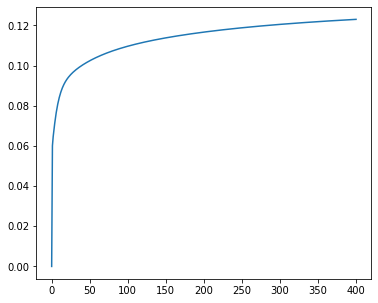

In [ ]:
fig = plt.figure(figsize=(6,5))
plt.plot(weights_change_list)